In [1]:
import os
import librosa
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score
import librosa.display
import scipy.fftpack as fftpack
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


In [2]:
train_path = 'E:/Queenless/20k_audio_splitted_dataset/train'
val_path = 'E:/Queenless/20k_audio_splitted_dataset/val'
test_path = 'E:/Queenless/20k_audio_splitted_dataset/test'

output_dir = 'E:/Queenless/features'
os.makedirs(output_dir, exist_ok=True)

# MFCCs

In [5]:
def pre_emphasis(signal_in, alpha=0.97):
    """
    Bước 1: Pre-emphasis - Lọc thông cao
    """
    emphasized_signal = np.append(signal_in[0], signal_in[1:] - alpha * signal_in[:-1]) # y(t) = x(t) - alpha*x(t-1)
    return emphasized_signal

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Bước 2: Chia khung (Framing)
    - frame_size: kích thước khung (số giây)
    - frame_stride: bước nhảy giữa các khung (số giây)
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    # Zero-padding nếu cần
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Bước 3: Áp dụng cửa sổ Hamming cho mỗi khung
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    windowed_frames = frames * hamming
    return windowed_frames

def fft_frames(frames, NFFT=512):
    """
    Bước 4: Tính FFT cho mỗi khung
    """
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    return mag_frames

def power_spectrum(mag_frames, NFFT=512):
    """
    Bước 4.1: Tính phổ công suất của mỗi khung
    """
    return (1.0 / NFFT) * (mag_frames ** 2)

def mel_filterbank(sample_rate, NFFT, nfilt=26, low_freq=0, high_freq=None):
    """
    Bước 5: Tạo Mel filterbank
    """
    if high_freq is None:
        high_freq = sample_rate / 2

    # Chuyển Hz sang Mel
    low_mel = 2595 * np.log10(1 + low_freq / 700.0)
    high_mel = 2595 * np.log10(1 + high_freq / 700.0)
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    # Chuyển lại từ Mel sang Hz
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # giới hạn trái
        f_m = int(bin[m])             # trung tâm
        f_m_plus = int(bin[m + 1])    # giới hạn phải

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

# Hàm tính mfccs
def compute_mfccs(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, 
                 pre_emph=0.97, NFFT=512, nfilt=26, num_ceps=13):
    emphasized_signal = pre_emphasis(signal_in, pre_emph)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    pow_frames = power_spectrum(mag_frames, NFFT)
    fbank = mel_filterbank(sample_rate, NFFT, nfilt)
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbank = np.log(filter_banks)
    mfccs = fftpack.dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfccs

In [7]:

def extract_mfccs_features(directory, sample_rate=22050, output_dir=None, dataset_type='train'):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'mfccs_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'mfccs_labels_{dataset_type}.pkl')
    data_file = os.path.join(output_dir, f'mfccs_data_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(data_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
        data = joblib.load(data_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        data = []  # Thêm một biến để lưu dữ liệu đầu vào (có thể là tín hiệu, ví dụ như signal hoặc các thông tin khác)
        
        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                mfccs = compute_mfccs(signal_in=signal, sample_rate=sr)
                mfccs_mean = np.mean(mfccs, axis=0)
                features.append(mfccs_mean)
                labels.append(label)
                data.append(signal)  # Lưu tín hiệu âm thanh gốc hoặc dữ liệu khác nếu cần
        
        features = np.array(features)
        labels = np.array(labels)
        data = np.array(data)  # Chuyển dữ liệu sang dạng numpy array nếu cần lưu
        
        if output_dir:
            # Lưu từng đối tượng riêng biệt cho train/val/test
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
            joblib.dump(data, data_file)  # Lưu tín hiệu âm thanh hoặc dữ liệu
        
        end_time = time.time()
        print(f"MFCCs extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels, data

train_features_mfccs, train_labels_mfccs, train_data_mfccs = extract_mfccs_features(train_path, output_dir=output_dir, dataset_type='train')
val_features_mfccs, val_labels_mfccs, val_data_mfccs = extract_mfccs_features(val_path, output_dir=output_dir, dataset_type='val')
test_features_mfccs, test_labels_mfccs, test_data_mfccs = extract_mfccs_features(test_path, output_dir=output_dir, dataset_type='test')
train_features_mfccs = np.vstack((train_features_mfccs, val_features_mfccs))
train_labels_mfccs = np.hstack((train_labels_mfccs, val_labels_mfccs))
train_data_mfccs = np.vstack((train_data_mfccs, val_data_mfccs))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [10]:
print(train_features_mfccs.shape)
print(test_features_mfccs.shape)

(16076, 13)
(4000, 13)


In [11]:
train_features_mfccs[0, :]

array([-84.59486884,   6.34044745,  -2.47652946,   5.6866161 ,
        -6.0883983 ,   3.79775816,  -4.57106924,   2.68850088,
        -2.55462216,   1.96805757,  -1.50288011,   0.65516511,
        -0.11471445])

In [12]:
scaler = StandardScaler()
train_features_mfccs_scaled = scaler.fit_transform(train_features_mfccs)
test_features_mfccs_scaled = scaler.transform(test_features_mfccs)

MFCCs - RF

In [13]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
rf_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_predictions = rf_classifier.predict(test_features_mfccs_scaled)
test_accuracy_mfccs_rf = accuracy_score(test_labels_mfccs, test_predictions)
print(f"Test Accuracy: {test_accuracy_mfccs_rf * 100:.2f}%")


Training time: 11.29 seconds
Test Accuracy: 92.42%


Tuning bootstrap=False from 92% to 92.38%

MFCCs - SVM

In [14]:
start_time = time.time()

svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma=1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_svm = accuracy_score(test_labels_mfccs, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_mfccs_svm * 100:.2f}%")

Training time: 13.13 seconds
Test Accuracy (SVM with RBF Kernel): 94.10%


In [15]:
start_time = time.time()

# Khởi tạo mô hình SVM với data scaling
svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma=1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_svm = accuracy_score(test_labels_mfccs, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_mfccs_svm * 100:.2f}%")

Training time: 31.61 seconds
Test Accuracy (SVM with RBF Kernel): 94.27%


Scaling data improve from 94% to 94.05%

MFCCs - LR

In [16]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_lr = accuracy_score(test_labels_mfccs, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {test_accuracy_mfccs_lr * 100:.2f}%")

Training time: 0.09 seconds
Test Accuracy (Logistic Regression): 72.60%


In [17]:
start_time = time.time()

# Khởi tạo mô hình Logistic Regression với data scaling
lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='liblinear', max_iter=100, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

# Huấn luyện mô hình Logistic Regression với dữ liệu đã chuẩn hóa
lr_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_lr = lr_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_lr = accuracy_score(test_labels_mfccs, test_predictions_lr)
print(f"Test Accuracy (Logistic Regression): {scale_test_accuracy_mfccs_lr * 100:.2f}%")

Training time: 0.04 seconds
Test Accuracy (Logistic Regression): 73.22%


Tuned the LR model but still only has 73.28% accuracy -> problem with feature extraction method?

MFCCs - ET

In [18]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees 
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_et = accuracy_score(test_labels_mfccs, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_mfccs_et * 100:.2f}%")


Training time: 7.14 seconds
Test Accuracy (Extra Trees): 92.97%


In [19]:
start_time = time.time()

# Khởi tạo mô hình Extra Trees với data scaling
et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_et = accuracy_score(test_labels_mfccs, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_mfccs_et * 100:.2f}%")


Training time: 7.18 seconds
Test Accuracy (Extra Trees): 92.95%


Model tuning improved from 92.53% to 92.97%

MFCCs - KNN

In [20]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_features_mfccs, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")


# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_features_mfccs)
test_accuracy_mfccs_knn = accuracy_score(test_labels_mfccs, test_predictions_knn)
print(f"Test Accuracy (KNN): {test_accuracy_mfccs_knn * 100:.2f}%")

Training time: 0.07 seconds
Test Accuracy (KNN): 91.77%


In [21]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

# Huấn luyện mô hình KNN với dữ liệu đã chuẩn hóa
knn_classifier.fit(train_features_mfccs_scaled, train_labels_mfccs)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_knn = knn_classifier.predict(test_features_mfccs_scaled)
scale_test_accuracy_mfccs_knn = accuracy_score(test_labels_mfccs, test_predictions_knn)
print(f"Test Accuracy (KNN): {scale_test_accuracy_mfccs_knn * 100:.2f}%")

Training time: 0.04 seconds
Test Accuracy (KNN): 92.95%


# FFTs (with pre-emphasis, framing, windowing)

In [68]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
      
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    return fft_feature


In [23]:
import numpy as np

def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    pad_signal = np.pad(signal_in, (0, pad_signal_length - signal_length), mode='constant')

    indices = np.arange(0, frame_length) + np.arange(0, num_frames * frame_step, frame_step)[:, None]
    frames = pad_signal[indices.astype(np.int32)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.abs(np.fft.fft(frames, NFFT))[:, :NFFT//2+1]  # Chỉ lấy giá trị magnitude dương

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    
    # Áp dụng log nếu cần, đảm bảo không có log(0)
    if apply_log:
        fft_feature = np.log(np.maximum(fft_feature, 1e-8))  # Thêm epsilon để tránh log(0)
    
    return fft_feature


In [24]:
def load_fft_features_from_directory(directory, sample_rate=22050, NFFT=512, output_dir=None, dataset_type='train'):
    """
    Duyệt qua các file âm thanh trong thư mục và tính đặc trưng FFT cho mỗi file.
    Giả sử trong directory có hai thư mục con: 'Queen' và 'NonQueen'.
    
    Trả về:
      - features: mảng đặc trưng (mỗi đặc trưng có kích thước NFFT/2+1)
      - labels: nhãn tương ứng.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'fft3_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'fft3_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                fft_feature = compute_fft_features(signal, sr, NFFT=NFFT)
                features.append(fft_feature)
                labels.append(label)
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"FFT extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

In [25]:
train_features_fft, train_labels_fft = load_fft_features_from_directory(train_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='train')
val_features_fft, val_labels_fft = load_fft_features_from_directory(val_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='val')
test_features_fft, test_labels_fft = load_fft_features_from_directory(test_path, sample_rate=22050, NFFT=512, output_dir=output_dir, dataset_type='test')

train_features_fft = np.vstack((train_features_fft, val_features_fft))
train_labels_fft = np.hstack((train_labels_fft, val_labels_fft))    

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [27]:
scaler = StandardScaler()
train_features_fft_scaled = scaler.fit_transform(train_features_fft)
test_features_fft_scaled = scaler.transform(test_features_fft)

FFTs - KNN

In [28]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.01 seconds
KNN (FFT features) - Test Accuracy: 95.53%


94.25% to 95.15%, pre_emph = 0.98 => 95.28

In [30]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_knn = knn_classifier.predict(test_features_fft_scaled)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_knn)*100:.2f}%")

Training time: 0.01 seconds
KNN (FFT features) - Test Accuracy: 94.65%


94.25%, pre_emph = 0.98 => 94.42

FFTs - SVM

In [31]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft)
test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_fft_svm * 100:.2f}%")

Training time: 15.34 seconds
Test Accuracy (SVM with RBF Kernel): 97.60%


97.47%

In [32]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_svm = accuracy_score(test_labels_fft, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_fft_svm * 100:.2f}%")

Training time: 62.01 seconds
Test Accuracy (SVM with RBF Kernel): 97.82%


97.82

FFTs - LR

In [33]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_lr = lr_classifier.predict(test_features_fft)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_lr)*100:.2f}%")


Training time: 3.07 seconds
Logistic Regression (FFT features) - Test Accuracy: 86.67%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_fft_lr = lr_classifier.predict(test_features_fft_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, scale_test_accuracy_fft_lr)*100:.2f}%")


Training time: 69.04 seconds
Logistic Regression (FFT features) - Test Accuracy: 86.35%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Tuning from 85.97% to 86.05%

Using min max scaling -> 86.08%

But Non-scaling data working better -> 86.33%

FFTs - RF

In [35]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_fft_rf = rf_classifier.predict(test_features_fft)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels_fft, test_accuracy_fft_rf)*100:.2f}%")

Training time: 37.20 seconds
Random Forest (FFT features) - Test Accuracy: 94.62%


Not tuning yet

FFTs - ET

In [36]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features_fft, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft)
test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_fft_et * 100:.2f}%")


Training time: 124.75 seconds
Test Accuracy (Extra Trees): 96.00%


In [37]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_fft_scaled, train_labels_fft)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_fft_scaled)
scale_test_accuracy_fft_et = accuracy_score(test_labels_fft, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_fft_et * 100:.2f}%")


Training time: 128.48 seconds
Test Accuracy (Extra Trees): 95.97%


93.95% -> 95.80% beautifull

# MFCC (lib)

In [6]:
def compute_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000) 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=n_mfcc, dct_type=2, norm='ortho', lifter=0)
    return mfcc

In [7]:
def extract_mfcc_features(directory, sample_rate=22050, output_dir=None, dataset_type='train', reduce_dimension=True):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'mfcc2_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'mfcc2_labels_{dataset_type}.pkl')
    data_file = os.path.join(output_dir, f'mfcc2_data_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file) and os.path.exists(data_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
        data = joblib.load(data_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        data = []  # Thêm một biến để lưu dữ liệu đầu vào (có thể là tín hiệu, ví dụ như signal hoặc các thông tin khác)
        
        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                mfcc = compute_mfcc(file_path=file_path, n_mfcc=70)  # Chiết xuất MFCC cho mỗi tệp âm thanh
                features.append(mfcc)  # Lưu ma trận MFCC cho mỗi tệp âm thanh
                labels.append(label)
        
        features = np.array(features)
        labels = np.array(labels)
        data = np.array(data)  # Chuyển dữ liệu sang dạng numpy array nếu cần lưu
        
        # Nếu cần giảm chiều theo axis=2
        if reduce_dimension:
            features = np.mean(features, axis=2)
        
        if output_dir:
            # Lưu từng đối tượng riêng biệt cho train/val/test
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
            joblib.dump(data, data_file)  # Lưu tín hiệu âm thanh hoặc dữ liệu
        
        end_time = time.time()
        print(f"MFCC extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels, data

# Gọi hàm với tham số reduce_dimension=True để giảm chiều ngay khi gọi hàm
train_features_mfcc, train_labels_mfcc, train_data_mfcc = extract_mfcc_features(train_path, output_dir=output_dir, dataset_type='train')
val_features_mfcc, val_labels_mfcc, val_data_mfcc = extract_mfcc_features(val_path, output_dir=output_dir, dataset_type='val')
test_features_mfcc, test_labels_mfcc, test_data_mfcc = extract_mfcc_features(test_path, output_dir=output_dir, dataset_type='test')
train_features_mfcc = np.vstack((train_features_mfcc, val_features_mfcc))
train_labels_mfcc = np.hstack((train_labels_mfcc, val_labels_mfcc))    
train_data_mfcc = np.vstack((train_data_mfcc, val_data_mfcc))

Extracting train data...
MFCC extraction time: 271.60 seconds
Extracting val data...
MFCC extraction time: 36.73 seconds
Extracting test data...
MFCC extraction time: 73.64 seconds


In [8]:
train_features_mfcc.shape

(16076, 70)

In [9]:
scaler = StandardScaler()
train_features_mfcc_scaled = scaler.fit_transform(train_features_mfcc)
test_features_mfcc_scaled = scaler.transform(test_features_mfcc)

In [10]:
start_time = time.time()

svm_rbf_classifier = SVC(C=8.31, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_mfcc_scaled, train_labels_mfcc)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_mfcc_scaled)
scale_test_accuracy_mfcc_svm = accuracy_score(test_labels_mfcc, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_mfcc_svm * 100:.2f}%")

Training time: 6.94 seconds
Test Accuracy (SVM with RBF Kernel): 98.38%


98.55%

# STFTs

In [11]:
import numpy as np
import librosa
import os

def apply_preprocessing(signal_in, sample_rate):
    """
    Apply optional preprocessing steps on the signal:
      - Apply pre-emphasis filtering.
    """
    # Pre-emphasis filter: Boosting higher frequencies slightly
    pre_emphasis = 0.97
    signal_in = np.append(signal_in[0], signal_in[1:] - pre_emphasis * signal_in[:-1])
    return signal_in

def frame_signal(signal, frame_size, hop_length):
    """
    Convert a signal into overlapping frames.
    
    Args:
        signal: Input audio signal
        frame_size: Number of samples per frame
        hop_length: Number of samples between frames
    
    Returns:
        numpy.ndarray: Framed signal of shape (frame_length, num_frames)
    """
    # Calculate the number of frames
    num_frames = 1 + int((len(signal) - frame_size) / hop_length)
    
    # Create an empty array to store frames
    frames = np.zeros((frame_size, num_frames))
    
    # Frame the signal
    for i in range(num_frames):
        start = i * hop_length
        end = start + frame_size
        if end <= len(signal):
            frames[:, i] = signal[start:end]
        else:  # Zero padding for last frame if needed
            frames[:len(signal)-start, i] = signal[start:]
    
    return frames

def apply_window(frames, window_type='hann'):
    """
    Apply a window function to each frame.
    
    Args:
        frames: Framed signal of shape (frame_length, num_frames)
        window_type: Type of window function ('hann', 'hamming', 'blackman', etc.)
    
    Returns:
        numpy.ndarray: Windowed frames
    """
    # Create the window function
    frame_length = frames.shape[0]
    window = np.zeros(frame_length)
    
    if window_type == 'hann':
        window = np.hanning(frame_length)
    elif window_type == 'hamming':
        window = np.hamming(frame_length)
    elif window_type == 'blackman':
        window = np.blackman(frame_length)
    else:  # Default to Hann window
        window = np.hanning(frame_length)
    
    # Apply window to each frame (element-wise multiplication)
    return frames * window.reshape(-1, 1)

def compute_stfts_features(signal_in, sample_rate, n_fft=2048, hop_length=512, 
                          window_type='hann', apply_log=True):
    """
    Compute STFT features with explicitly separated steps:
      - Apply preprocessing (pre-emphasis)
      - Frame the signal into overlapping segments
      - Apply windowing to each frame
      - Compute STFT
      - Extract features with optional log scaling
    """
    # Apply preprocessing (e.g., pre-emphasis)
    signal_in = apply_preprocessing(signal_in, sample_rate)
    
    # Explicit framing and windowing (for demonstration, though librosa.stft does this internally)
    frames = frame_signal(signal_in, n_fft, hop_length)
    windowed_frames = apply_window(frames, window_type)
    
    # Note: In practice, we could use these windowed frames directly for FFT
    # but for compatibility with the original code, we'll use librosa.stft
    
    # Compute STFT with a window function to avoid spectral leakage
    stfts_matrix = np.abs(librosa.stft(signal_in, n_fft=n_fft, hop_length=hop_length, window=window_type))
    
    # Optional: Apply logarithmic scaling (dynamic range compression)
    if apply_log:
        stfts_matrix = np.log(stfts_matrix + 1e-10)  # More robust epsilon for log scaling

    # Feature extraction: Mean and additional energy-based features (e.g., variance)
    features_mean = np.mean(stfts_matrix, axis=1)
    features_variance = np.var(stfts_matrix, axis=1)
    
    # Combine mean and variance (you could also add other stats like median or skewness)
    features = np.concatenate([features_mean, features_variance], axis=0)

    # Normalize the features (optional)
    features = (features - np.mean(features)) / np.std(features)  # Z-score normalization

    return features

def process_audio_file(file_path, n_fft=2048, hop_length=512, window_type='hann'):
    """
    Process an audio file to extract STFT features.
    
    Args:
        file_path: Path to the audio file
        n_fft: FFT window size
        hop_length: Hop length between frames
        window_type: Type of window function to apply
        
    Returns:
        numpy.ndarray: Extracted features
    """
    # Load the audio file
    signal, sample_rate = librosa.load(file_path, sr=None)
    
    # Compute features
    features = compute_stfts_features(signal, sample_rate, n_fft, hop_length, window_type)
    
    return features

In [12]:
def load_stfts_features_from_directory(directory, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=None, dataset_type='train'):
    """
    Load and compute stfts features from audio files in a directory, with improved accuracy.
    Assumes 'Queen' and 'NonQueen' subdirectories are present.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'stfts_features_{dataset_type}1.pkl')
    labels_file = os.path.join(output_dir, f'stfts_labels_{dataset_type}1.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type}1 data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []

        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                # Load audio file
                signal, sr = librosa.load(file_path, sr=sample_rate)

                # Compute stfts features
                stfts_feature = compute_stfts_features(signal, sr, n_fft=n_fft, hop_length=hop_length, apply_log=True)

                features.append(stfts_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)

        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)

        end_time = time.time()
        print(f"STFTs extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

train_features_stfts, train_labels_stfts = load_stfts_features_from_directory(train_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='train')
val_features_stfts, val_labels_stfts = load_stfts_features_from_directory(val_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='val')
test_features_stfts, test_labels_stfts = load_stfts_features_from_directory(test_path, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=output_dir, dataset_type='test')
train_features_stfts = np.vstack((train_features_stfts, val_features_stfts))
train_labels_stfts = np.hstack((train_labels_stfts, val_labels_stfts))

Loading train1 data from .pkl files...
Loading val1 data from .pkl files...
Loading test1 data from .pkl files...


In [13]:
scaler_stfts = StandardScaler()
train_features_stfts_scaled = scaler_stfts.fit_transform(train_features_stfts)
test_features_stfts_scaled  = scaler_stfts.transform(test_features_stfts)


STFTs - KNN

In [14]:
start_time = time.time()

knn_classifier_stfts = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                           metric='minkowski', metric_params=None, n_jobs=None)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

knn_classifier_stfts.fit(train_features_stfts, train_labels_stfts)
test_pred_stfts_knn = knn_classifier_stfts.predict(test_features_stfts)

test_accuracy_stfts_knn = accuracy_score(test_labels_stfts, test_pred_stfts_knn)
print(f"KNN (STFTs) - Test Accuracy: {test_accuracy_stfts_knn*100:.2f}%")


Training time: 0.00 seconds
KNN (STFTs) - Test Accuracy: 93.62%


Old 95.10%

In [15]:
start_time = time.time()

knn_classifier_stfts = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                           metric='minkowski', metric_params=None, n_jobs=None)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

knn_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)
test_pred_stfts_knn = knn_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_knn = accuracy_score(test_labels_stfts, test_pred_stfts_knn)
print(f"KNN (STFTs) - Test Accuracy: {test_accuracy_stfts_knn*100:.2f}%")


Training time: 0.00 seconds
KNN (STFTs) - Test Accuracy: 92.58%


Old 94.50%

STFTs - SVM

In [16]:
start_time = time.time()

svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_stfts_scaled)
scale_test_accuracy_stfts_svm = accuracy_score(test_labels_stfts, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_stfts_svm * 100:.2f}%")

Training time: 401.53 seconds
Test Accuracy (SVM with RBF Kernel): 95.60%


STFTs - LR

In [17]:
start_time = time.time()

lr_classifier_stfts = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', penalty= 'l2', C= 0.08858667904100823)
lr_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_stfts_lr = lr_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_lr = accuracy_score(test_labels_stfts, test_pred_stfts_lr)
print(f"Logistic Regression (STFTs) - Test Accuracy: {test_accuracy_stfts_lr*100:.2f}%")

Training time: 41.69 seconds
Logistic Regression (STFTs) - Test Accuracy: 88.95%


STFTs - RF

In [18]:
start_time = time.time()

rf_classifier_stfts = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier_stfts.fit(train_features_stfts, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

val_pred_stfts_rf = rf_classifier_stfts.predict(val_features_stfts)
test_pred_stfts_rf = rf_classifier_stfts.predict(test_features_stfts)

test_accuracy_stfts_rf = accuracy_score(test_labels_stfts, test_pred_stfts_rf)
print(f"Random Forest (STFTs) - Test Accuracy: {test_accuracy_stfts_rf*100:.2f}%")


Training time: 184.78 seconds
Random Forest (STFTs) - Test Accuracy: 93.30%


STFTs - ET

In [19]:
start_time

et_classifier_stfts = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier_stfts.fit(train_features_stfts_scaled, train_labels_stfts)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_stfts_et = et_classifier_stfts.predict(test_features_stfts_scaled)

test_accuracy_stfts_et = accuracy_score(test_labels_stfts, test_pred_stfts_et)
print(f"Extra Trees (STFTs) - Test Accuracy: {test_accuracy_stfts_et*100:.2f}%")


Training time: 211.25 seconds
Extra Trees (STFTs) - Test Accuracy: 91.97%


# CQT

In [20]:
def compute_cqt_features(signal_in, sample_rate, hop_length=512, fmin=None, 
                         n_bins=84, bins_per_octave=12, apply_log=True):
    """
    Tính đặc trưng CQT của tín hiệu:
      - Sử dụng librosa.cqt để tính ma trận CQT, lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling để giảm phạm vi giá trị.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_bins,).
      
    Nếu fmin không được chỉ định, librosa sẽ tự động sử dụng fmin mặc định.
    """
    cqt_matrix = np.abs(librosa.cqt(signal_in, sr=sample_rate, hop_length=hop_length,
                                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave))
    if apply_log:
        cqt_matrix = np.log(cqt_matrix + 1e-8)
    # Trung bình theo trục thời gian (tính trung bình các cột)
    features = np.mean(cqt_matrix, axis=1)
    return features


In [21]:
def load_cqt_features_from_directory(directory, sample_rate=22050, hop_length=512, 
                                     fmin=None, n_bins=84, bins_per_octave=12, output_dir=None, dataset_type='train'):
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'cqt_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'cqt_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                signal, sr = librosa.load(file_path, sr=sample_rate)
                
                # Compute CQT features
                cqt_feature = compute_cqt_features(signal, sr, hop_length=hop_length, 
                                                   fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, 
                                                   apply_log=True)
                
                features.append(cqt_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"CQT extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

train_features_cqt, train_labels_cqt = load_cqt_features_from_directory(train_path, sample_rate=22050,
                                                                        hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                        output_dir=output_dir, dataset_type='train')
val_features_cqt, val_labels_cqt = load_cqt_features_from_directory(val_path, sample_rate=22050,
                                                                    hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                    output_dir=output_dir, dataset_type='val')
test_features_cqt, test_labels_cqt = load_cqt_features_from_directory(test_path, sample_rate=22050,
                                                                      hop_length=512, fmin=None, n_bins=84, bins_per_octave=12, 
                                                                      output_dir=output_dir, dataset_type='test')

train_features_cqt = np.vstack((train_features_cqt, val_features_cqt))
train_labels_cqt = np.hstack((train_labels_cqt, val_labels_cqt))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [22]:
scaler_cqt = StandardScaler()
train_features_cqt_scaled = scaler_cqt.fit_transform(train_features_cqt)
test_features_cqt_scaled  = scaler_cqt.transform(test_features_cqt)

CQT - KNN

In [23]:
start_time = time.time()

knn_classifier_cqt = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

knn_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_knn = knn_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_knn = accuracy_score(test_labels_cqt, test_pred_cqt_knn)
print(f"KNN (CQT) - Test Accuracy: {test_accuracy_cqt_knn*100:.2f}%")


Training time: 0.01 seconds
KNN (CQT) - Test Accuracy: 97.85%


CQT - SVM

In [24]:
start_time = time.time()

svm_classifier_cqt = SVC(C=100, kernel='rbf', gamma='auto', random_state=42)
svm_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_svm = svm_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_svm = accuracy_score(test_labels_cqt, test_pred_cqt_svm)
print(f"SVM (CQT) - Test Accuracy: {test_accuracy_cqt_svm*100:.2f}%")


Training time: 9.46 seconds
SVM (CQT) - Test Accuracy: 97.12%


CQT - LR

In [25]:
start_time = time.time()

lr_classifier_cqt =LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                      fit_intercept=True, intercept_scaling=1, 
                                      class_weight=None, random_state=None, solver='lbfgs', 
                                      max_iter=500, multi_class='deprecated', verbose=0, 
                                      warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_lr = lr_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_lr = accuracy_score(test_labels_cqt, test_pred_cqt_lr)
print(f"Logistic Regression (CQT) - Test Accuracy: {test_accuracy_cqt_lr*100:.2f}%")


Training time: 0.25 seconds
Logistic Regression (CQT) - Test Accuracy: 83.55%


CQT - RF

In [26]:
start_time = time.time()

rf_classifier_cqt = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                                       min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                       bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, 
                                       warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier_cqt.fit(train_features_cqt, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_rf = rf_classifier_cqt.predict(test_features_cqt)

test_accuracy_cqt_rf = accuracy_score(test_labels_cqt, test_pred_cqt_rf)
print(f"Random Forest (CQT) - Test Accuracy: {test_accuracy_cqt_rf*100:.2f}%")


Training time: 33.02 seconds
Random Forest (CQT) - Test Accuracy: 95.35%


CQT - ET

In [27]:
start_time = time.time()

et_classifier_cqt = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier_cqt.fit(train_features_cqt_scaled, train_labels_cqt)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_et = et_classifier_cqt.predict(test_features_cqt_scaled)

test_accuracy_cqt_et = accuracy_score(test_labels_cqt, test_pred_cqt_et)
print(f"Extra Trees (CQT) - Test Accuracy: {test_accuracy_cqt_et*100:.2f}%")

Training time: 34.56 seconds
Extra Trees (CQT) - Test Accuracy: 95.97%


# FFT + CQT

In [3]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    
    Args:
        signal_in: Tín hiệu đầu vào
        pre_emph: Hệ số pre-emphasis, mặc định là 0.97
        
    Returns:
        Tín hiệu sau khi áp dụng pre-emphasis
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
      
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    return fft_feature

def compute_cqt_features(signal_in, sample_rate, fmin=None, 
                         n_bins=84, bins_per_octave=12, apply_log=True):
    """
    Tính đặc trưng CQT của tín hiệu:
      - Sử dụng librosa.cqt để tính ma trận CQT, lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling để giảm phạm vi giá trị.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_bins,).
      
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        fmin: Tần số thấp nhất (Hz). Nếu None, librosa sẽ sử dụng mặc định
        n_bins: Số lượng bin tần số
        bins_per_octave: Số lượng bin cho mỗi quãng 8
        apply_log: Áp dụng logarit cho đặc trưng
        
    Returns:
        Vector đặc trưng CQT có kích thước (n_bins,)
    """
    cqt_matrix = np.abs(librosa.cqt(signal_in, sr=sample_rate,
                                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave))
    
    # Trung bình theo trục thời gian (tính trung bình các cột)
    cqt_feature = np.mean(cqt_matrix, axis=1)
    
    # Áp dụng logarithm (nếu cần)
    if apply_log:
        cqt_feature = np.log(cqt_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    
    return cqt_feature

def compute_features(signal_in, sample_rate, frame_size=0.025,
                     NFFT=512,
                     fmin=None, n_bins=84, bins_per_octave=12, apply_log=True):
    """
    Tính toán và kết hợp đặc trưng FFT và CQT cho tín hiệu âm thanh.
    
    Args:
        signal_in: Tín hiệu đầu vào
        sample_rate: Tần số lấy mẫu
        frame_size: Kích thước frame cho FFT (giây hoặc số mẫu nếu > 1)
        NFFT: Số điểm FFT
        fmin: Tần số thấp nhất (Hz) cho CQT
        n_bins: Số lượng bin tần số cho CQT
        bins_per_octave: Số lượng bin cho mỗi quãng 8 cho CQT
        apply_log: Áp dụng logarit cho đặc trưng
        
    Returns:
        Vector đặc trưng kết hợp FFT và CQT
    """
    # Tính đặc trưng FFT
    fft_feature = compute_fft_features(
        signal_in, sample_rate, frame_size=frame_size,
        NFFT=NFFT,
        apply_log=apply_log
    )
    
    # Tính đặc trưng CQT
    cqt_feature = compute_cqt_features(
        signal_in, sample_rate, fmin=fmin,
        n_bins=n_bins, bins_per_octave=bins_per_octave,
        apply_log=apply_log
    )
    
    # Kết hợp hai đặc trưng
    combined_feature = np.concatenate((fft_feature, cqt_feature))
    
    return combined_feature

def load_features_from_directory(directory, sample_rate=22050, NFFT=512, 
                                 frame_size=0.025,
                                 output_dir=None, 
                                 dataset_type='train',
                                 fmin=None, n_bins=84, bins_per_octave=12):
    """
    Duyệt qua các file âm thanh trong thư mục và tính đặc trưng kết hợp FFT và CQT cho mỗi file.
    
    Args:
        directory: Thư mục chứa dữ liệu âm thanh
        sample_rate: Tần số lấy mẫu
        NFFT: Số điểm FFT
        frame_size: Kích thước frame (giây hoặc số mẫu nếu > 1)
        output_dir: Thư mục đầu ra để lưu đặc trưng
        dataset_type: Loại tập dữ liệu ('train', 'test', 'val')
        fmin: Tần số thấp nhất (Hz) cho CQT
        n_bins: Số lượng bin tần số cho CQT
        bins_per_octave: Số lượng bin cho mỗi quãng 8 cho CQT
        
    Returns:
        features: Mảng đặc trưng kết hợp
        labels: Nhãn tương ứng
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'combined_features2_{dataset_type}_nfft{NFFT}_bins{n_bins}.pkl')
    labels_file = os.path.join(output_dir, f'combined_labels2_{dataset_type}_nfft{NFFT}_bins{n_bins}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []
        
        for label in ['NonQueen', 'Queen']:
            path = os.path.join(directory, label)
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist. Skipping.")
                continue
                
            for file in os.listdir(path):
                if not file.endswith(('.wav', '.mp3', '.flac', '.ogg')):
                    continue
                    
                file_path = os.path.join(path, file)
                try:
                    signal, sr = librosa.load(file_path, sr=sample_rate)
                    
                    # Tính toán đặc trưng kết hợp FFT và CQT
                    combined_feature = compute_features(
                        signal, sr, frame_size=frame_size,
                        NFFT=NFFT,
                        fmin=fmin, n_bins=n_bins, 
                        bins_per_octave=bins_per_octave
                    )
                    
                    features.append(combined_feature)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {str(e)}")
        
        features = np.array(features)
        labels = np.array(labels)
        
        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)
        
        end_time = time.time()
        print(f"Feature extraction time: {end_time - start_time:.2f} seconds")
        print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")
    
    return features, labels

# Trích xuất đặc trưng kết hợp cho tập dữ liệu
train_features, train_labels = load_features_from_directory(
    train_path, sample_rate=22050, NFFT=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='train'
)

val_features, val_labels = load_features_from_directory(
    val_path, sample_rate=22050, NFFT=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='val'
)

test_features, test_labels = load_features_from_directory(
    test_path, sample_rate=22050, NFFT=512, fmin=None, n_bins=96, bins_per_octave=12,
    output_dir=output_dir, dataset_type='test'
)

train_features = np.vstack((train_features, val_features))
train_labels = np.hstack((train_labels, val_labels))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [36]:
train_features.shape

(16076, 353)

In [37]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled  = scaler.transform(test_features)

In [38]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_knn = knn_classifier.predict(test_features)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_knn)*100:.2f}%")

Training time: 0.02 seconds
KNN (FFT features) - Test Accuracy: 97.47%


In [39]:
start_time = time.time()

knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_knn = knn_classifier.predict(test_features_scaled)
print(f"KNN (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_knn)*100:.2f}%")

Training time: 0.02 seconds
KNN (FFT features) - Test Accuracy: 97.28%


In [40]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

svm_rbf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 84.69 seconds
Test Accuracy (SVM with RBF Kernel): 98.60%


In [41]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)

# Huấn luyện mô hình SVM
svm_rbf_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features_scaled)
scale_test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {scale_test_accuracy_svm * 100:.2f}%")

Training time: 157.60 seconds
Test Accuracy (SVM with RBF Kernel): 98.20%


In [42]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='lbfgs', max_iter=1500, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
lr_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_lr = lr_classifier.predict(test_features)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_lr)*100:.2f}%")

Training time: 4.29 seconds
Logistic Regression (FFT features) - Test Accuracy: 88.30%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
start_time = time.time()

lr_classifier = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, 
                                   class_weight=None, random_state=42, solver='saga', max_iter=1000, multi_class='deprecated', 
                                   verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

lr_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

scale_test_accuracy_lr = lr_classifier.predict(test_features_scaled)
print(f"Logistic Regression (FFT features) - Test Accuracy: {accuracy_score(test_labels, scale_test_accuracy_lr)*100:.2f}%")

Training time: 95.42 seconds
Logistic Regression (FFT features) - Test Accuracy: 88.65%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [44]:
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=None, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_accuracy_rf = rf_classifier.predict(test_features)
print(f"Random Forest (FFT features) - Test Accuracy: {accuracy_score(test_labels, test_accuracy_rf)*100:.2f}%")

Training time: 44.20 seconds
Random Forest (FFT features) - Test Accuracy: 95.55%


In [45]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

et_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features)
test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {test_accuracy_et * 100:.2f}%")

Training time: 187.79 seconds
Test Accuracy (Extra Trees): 96.85%


In [46]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=30, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=None, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(test_features_scaled)
scale_test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_et * 100:.2f}%")



Training time: 186.33 seconds
Test Accuracy (Extra Trees): 96.85%


In [47]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                            max_depth=3, min_samples_split=2,
                            min_samples_leaf=1, subsample=1.0,
                            max_features='sqrt', random_state=42)

gb_classifier.fit(train_features_scaled, train_labels)

end_time = time.time()
print(f"Training time (Gradient Boosting): {end_time - start_time:.2f} seconds")

test_predictions_gb = gb_classifier.predict(test_features_scaled)
test_accuracy_gb = accuracy_score(test_labels, test_predictions_gb)
print(f"Test Accuracy (Gradient Boosting): {test_accuracy_gb * 100:.2f}%")
print("-" * 50)

Training time (Gradient Boosting): 16.04 seconds
Test Accuracy (Gradient Boosting): 90.85%
--------------------------------------------------


In [48]:
from sklearn.preprocessing import LabelEncoder
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Chuyển đổi các nhãn từ chuỗi sang số
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
val_labels_enc = le.transform(val_labels)
test_labels_enc = le.transform(test_labels)

start_time = time.time()

xgb_classifier = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42,
    use_label_encoder=False,    # Tắt cảnh báo về label encoder
    eval_metric='logloss'       # Chỉ định hàm mất mát
)
xgb_classifier.fit(train_features, train_labels_enc)

end_time = time.time()
print(f"Training time (XGBoost): {end_time - start_time:.2f} seconds")

# Đánh giá trên bộ testing
test_predictions_xgb = xgb_classifier.predict(test_features)
test_accuracy_xgb = accuracy_score(test_labels_enc, test_predictions_xgb)
print(f"Test Accuracy (XGBoost): {test_accuracy_xgb * 100:.2f}%")


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:25] WARNING: D:\bld\xgboost-split_1738880170463\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training time (XGBoost): 30.55 seconds
Test Accuracy (XGBoost): 97.32%


In [49]:
import lightgbm as lgb
import time
from sklearn.metrics import accuracy_score

start_time = time.time()

lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42
)
lgbm_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"\nTraining time (LightGBM): {end_time - start_time:.2f} seconds")

# Đánh giá trên bộ testing
test_predictions_lgbm = lgbm_classifier.predict(test_features)
test_accuracy_lgbm = accuracy_score(test_labels, test_predictions_lgbm)
print(f"Test Accuracy (LightGBM): {test_accuracy_lgbm * 100:.2f}%")


[LightGBM] [Info] Number of positive: 8000, number of negative: 8076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90015
[LightGBM] [Info] Number of data points in the train set: 16076, number of used features: 353
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497636 -> initscore=-0.009455
[LightGBM] [Info] Start training from score -0.009455

Training time (LightGBM): 2.35 seconds
Test Accuracy (LightGBM): 97.60%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# PCA

In [5]:
def separate_fft_cqt_features(combined_features, nfft=512, n_bins=96):
    """
    Tách đặc trưng kết hợp thành đặc trưng FFT và CQT riêng biệt.
    
    Args:
        combined_features: Mảng đặc trưng kết hợp FFT và CQT
        nfft: Số điểm FFT đã sử dụng khi tạo đặc trưng
        n_bins: Số lượng bin CQT đã sử dụng khi tạo đặc trưng
        
    Returns:
        fft_features: Mảng đặc trưng FFT
        cqt_features: Mảng đặc trưng CQT
    """
    fft_length = nfft // 2 + 1
    
    # Kiểm tra shape của mảng đầu vào
    if combined_features.ndim == 1:
        # Nếu là vector đơn, tách trực tiếp
        fft_features = combined_features[:fft_length]
        cqt_features = combined_features[fft_length:]
    else:
        # Nếu là batch, tách từng mẫu
        fft_features = combined_features[:, :fft_length]
        cqt_features = combined_features[:, fft_length:]
    
    return fft_features, cqt_features

train_fft, train_cqt = separate_fft_cqt_features(train_features, nfft=512, n_bins=96)
test_fft, test_cqt = separate_fft_cqt_features(test_features, nfft=512, n_bins=96)

print(f"Train combined features shape: {train_features.shape}")
print(f"Train FFT features shape: {train_fft.shape}")
print(f"Train CQT features shape: {train_cqt.shape}")

Train combined features shape: (16076, 353)
Train FFT features shape: (16076, 257)
Train CQT features shape: (16076, 96)


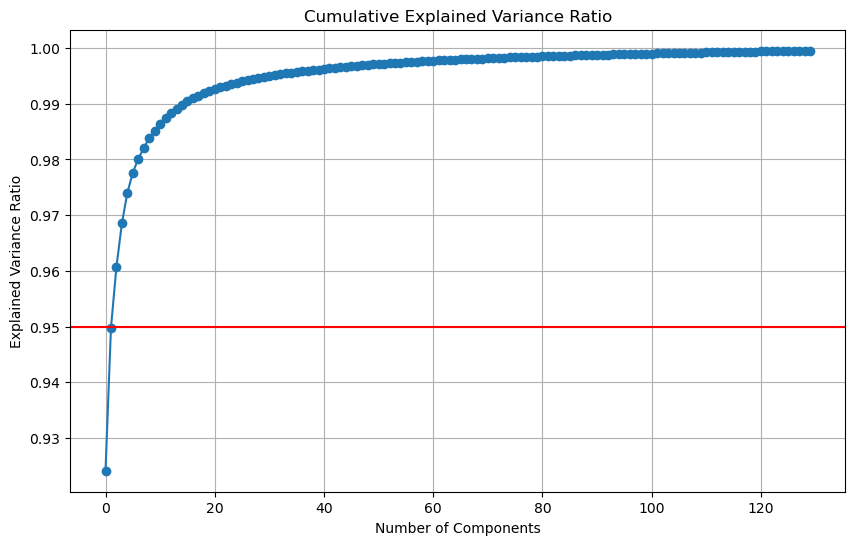

Number of components needed to explain 95% variance: 3
Top 5 principal components explain: 0.9740 of variance
Original FFT features shape: (16076, 257)
PCA FFT features shape: (16076, 130)


In [43]:
import matplotlib.pyplot as plt

def apply_pca_to_fft(fft_features, test_features=None, n_components=100, plot=True):
    """
    Áp dụng PCA để giảm số chiều của đặc trưng FFT.
    
    Args:
        fft_features: Mảng đặc trưng FFT cho tập huấn luyện
        test_features: Mảng đặc trưng FFT cho tập kiểm tra (nếu có)
        n_components: Số lượng thành phần chính muốn giữ lại
        plot: Vẽ đồ thị tỷ lệ phương sai giải thích được
        
    Returns:
        fft_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập huấn luyện
        test_pca: Đặc trưng FFT sau khi áp dụng PCA cho tập kiểm tra (nếu có)
        pca: Đối tượng PCA đã được huấn luyện
    """
    from sklearn.decomposition import PCA
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=53940)
    fft_pca = pca.fit_transform(fft_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance: {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance")
    
    return fft_pca, test_pca, pca

train_fft_pca, test_fft_pca, fft_pca = apply_pca_to_fft(
    train_fft, test_features=test_fft, n_components=130
)

print(f"Original FFT features shape: {train_fft.shape}")
print(f"PCA FFT features shape: {train_fft_pca.shape}")

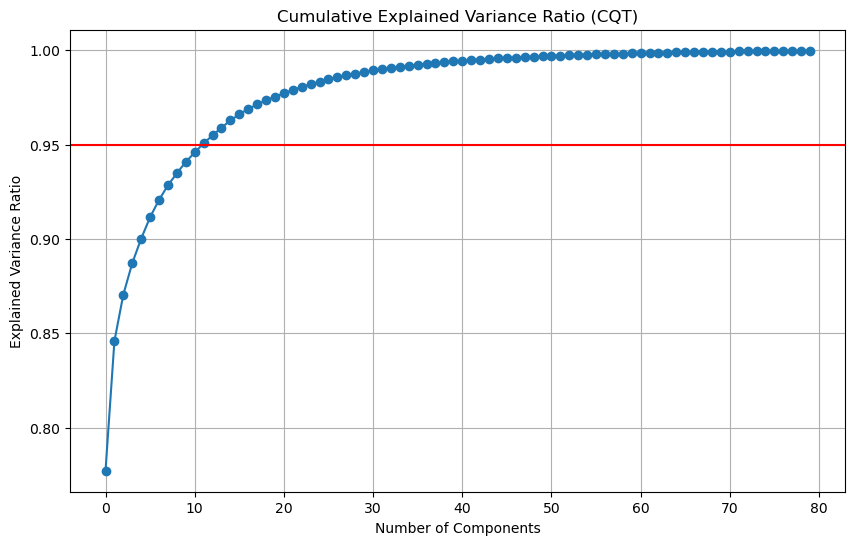

Number of components needed to explain 95% variance (CQT): 12
Top 5 principal components explain: 0.9002 of variance (CQT)
Original CQT features shape: (16076, 96)
PCA CQT features shape: (16076, 80)


In [44]:
def apply_pca_to_cqt(cqt_features, test_features=None, n_components=100, plot=True):
    """
    Áp dụng PCA để giảm số chiều của đặc trưng CQT.
    
    Args:
        cqt_features: Mảng đặc trưng CQT cho tập huấn luyện
        test_features: Mảng đặc trưng CQT cho tập kiểm tra (nếu có)
        n_components: Số lượng thành phần chính muốn giữ lại
        plot: Vẽ đồ thị tỷ lệ phương sai giải thích được
        
    Returns:
        cqt_pca: Đặc trưng CQT sau khi áp dụng PCA cho tập huấn luyện
        test_pca: Đặc trưng CQT sau khi áp dụng PCA cho tập kiểm tra (nếu có)
        pca: Đối tượng PCA đã được huấn luyện
    """
    from sklearn.decomposition import PCA
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=53940)
    cqt_pca = pca.fit_transform(cqt_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio (CQT)')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance (CQT): {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance (CQT)")
    
    return cqt_pca, test_pca, pca

# Áp dụng PCA cho CQT features
train_cqt_pca, test_cqt_pca, cqt_pca = apply_pca_to_cqt(
    train_cqt, test_features=test_cqt, n_components=80 
)

print(f"Original CQT features shape: {train_cqt.shape}")
print(f"PCA CQT features shape: {train_cqt_pca.shape}")

In [45]:
train_features = np.hstack((train_fft_pca, train_cqt_pca))
test_features = np.hstack((test_fft_pca, test_cqt_pca))

print(f"Combined features shape: {train_features.shape}")
print(f"Test combined features shape: {test_features.shape}")

Combined features shape: (16076, 210)
Test combined features shape: (4000, 210)


In [46]:
start_time = time.time()

svm_rbf_classifier = SVC(C=100, kernel='rbf', degree=3, gamma=0.1, coef0=0.0, shrinking=True, 
                         probability=False, tol=0.001, cache_size=500, class_weight=None, verbose=False, 
                         max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 19.04 seconds
Test Accuracy (SVM with RBF Kernel): 98.62%


In [51]:
train_features.shape

(16076, 210)

In [53]:
import numpy as np
import librosa

def compute_stft_features(signal_in, sample_rate, n_fft=2048, hop_length=512, apply_log=True):
    """
    Tính đặc trưng STFT của tín hiệu:
      - Tính STFT bằng librosa.stft và lấy giá trị magnitude.
      - (Tùy chọn) Áp dụng log scaling.
      - Trung bình theo trục thời gian (axis=1) để thu được vector đặc trưng có kích thước (n_fft/2+1,).
    """
    stft_matrix = np.abs(librosa.stft(signal_in, n_fft=n_fft, hop_length=hop_length))
    if apply_log:
        stft_matrix = np.log(stft_matrix + 1e-8)  # Thêm epsilon để tránh log(0)
    # Trung bình theo trục thời gian (tính trung bình các cột)
    features = np.mean(stft_matrix, axis=1)
    return features

In [57]:
def load_stft_features_from_directory(directory, sample_rate=22050, n_fft=2048, hop_length=512, output_dir=None, dataset_type='train'):
    """
    Load and compute stft features from audio files in a directory, with improved accuracy.
    Assumes 'Queen' and 'NonQueen' subdirectories are present.
    """
    # Kiểm tra nếu file đã tồn tại, thì load lại
    features_file = os.path.join(output_dir, f'stft2_features_{dataset_type}.pkl')
    labels_file = os.path.join(output_dir, f'stft2_labels_{dataset_type}.pkl')
    
    if os.path.exists(features_file) and os.path.exists(labels_file):
        print(f"Loading {dataset_type} data from .pkl files...")
        features = joblib.load(features_file)
        labels = joblib.load(labels_file)
    else:
        print(f"Extracting {dataset_type} data...")
        start_time = time.time()
        labels = []
        features = []

        for label in ['Queen', 'NonQueen']:
            path = os.path.join(directory, label)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                # Load audio file
                signal, sr = librosa.load(file_path, sr=sample_rate)

                # Compute stft features
                stft_feature = compute_stft_features(signal, sr, n_fft=n_fft, hop_length=hop_length, apply_log=True)

                features.append(stft_feature)
                labels.append(label)

        features = np.array(features)
        labels = np.array(labels)

        # Lưu dữ liệu vào file .pkl nếu chưa tồn tại
        if output_dir:
            joblib.dump(features, features_file)
            joblib.dump(labels, labels_file)

        end_time = time.time()
        print(f"stft extraction time: {end_time - start_time:.2f} seconds")
    
    return features, labels

stft_train_features, stft_train_labels = load_stft_features_from_directory(train_path, sample_rate=22050, n_fft=4096, hop_length=1024, output_dir=output_dir, dataset_type='train')
stft_val_features, stft_val_labels = load_stft_features_from_directory(val_path, sample_rate=22050, n_fft=4096, hop_length=1024, output_dir=output_dir, dataset_type='val')
stft_test_features, stft_test_labels = load_stft_features_from_directory(test_path, sample_rate=22050, n_fft=4096, hop_length=1024, output_dir=output_dir, dataset_type='test')

stft_train_features = np.vstack((stft_train_features, stft_val_features))
stft_train_labels = np.hstack((stft_train_labels, stft_val_labels))

Loading train data from .pkl files...
Loading val data from .pkl files...
Loading test data from .pkl files...


In [58]:
stft_train_features.shape

(16076, 2049)

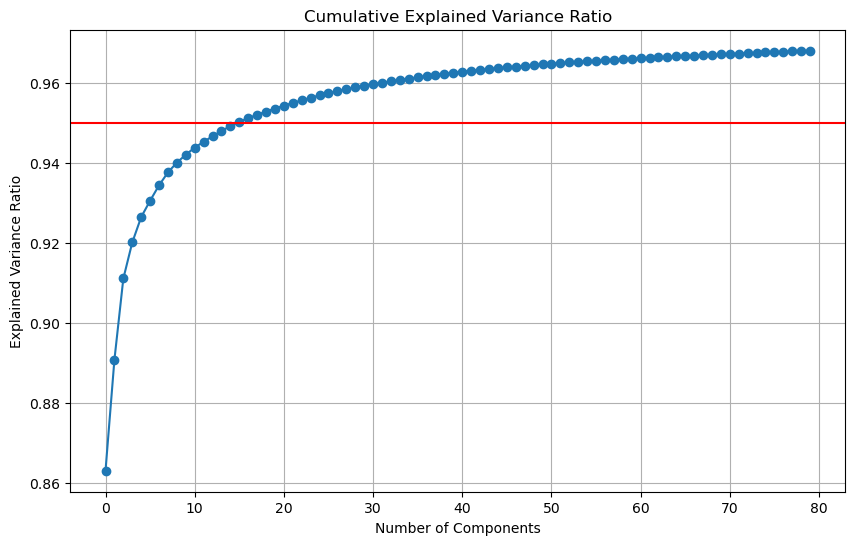

Number of components needed to explain 95% variance: 16
Top 5 principal components explain: 0.9265 of variance
Original STFT features shape: (16076, 2049)
PCA STFT features shape: (16076, 80)


In [59]:
def apply_pca_to_stft(stft_features, test_features=None, n_components=100, plot=True):
    from sklearn.decomposition import PCA
    
    # Khởi tạo và huấn luyện PCA
    pca = PCA(n_components=n_components, random_state=3951)
    fft_pca = pca.fit_transform(stft_features)
    
    # Áp dụng cho tập kiểm tra (nếu có)
    test_pca = None
    if test_features is not None:
        test_pca = pca.transform(test_features)
    
    # Vẽ đồ thị tỷ lệ phương sai giải thích được
    if plot:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_variance_ratio, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='-')
        plt.grid(True)
        plt.title('Cumulative Explained Variance Ratio')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        
        # Tìm số lượng thành phần cần thiết để giải thích 95% phương sai
        n_components_95 = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
        print(f"Number of components needed to explain 95% variance: {n_components_95}")
        
        # Hiển thị top 5 thành phần chính quan trọng nhất
        print(f"Top 5 principal components explain: {np.sum(explained_variance_ratio[:5]):.4f} of variance")
    
    return fft_pca, test_pca, pca

train_stft_pca, test_stft_pca, stft_pca = apply_pca_to_stft(
    stft_train_features, test_features=stft_test_features, n_components=80
)

print(f"Original STFT features shape: {stft_train_features.shape}")
print(f"PCA STFT features shape: {train_stft_pca.shape}")

In [60]:
combined_train_features = np.hstack((train_features, train_stft_pca))
combined_test_features = np.hstack((test_features, test_stft_pca))

In [61]:
combined_train_features.shape

(16076, 290)

In [78]:
start_time = time.time()

svm_rbf_classifier = SVC(C=10, kernel='rbf', degree=3, gamma=0.0075, 
                         coef0=0.0, shrinking=True, probability=False, tol=0.001, 
                         cache_size=500, class_weight=None, verbose=False, max_iter=-1, 
                         decision_function_shape='ovr', break_ties=False, random_state=42)


# Huấn luyện mô hình SVM trên dữ liệu kết hợp
svm_rbf_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_svm_rbf = svm_rbf_classifier.predict(combined_test_features)
test_accuracy_svm = accuracy_score(test_labels, test_predictions_svm_rbf)
print(f"Test Accuracy (SVM with RBF Kernel): {test_accuracy_svm * 100:.2f}%")

Training time: 12.30 seconds
Test Accuracy (SVM with RBF Kernel): 99.38%


In [146]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình Random Forest
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                       n_jobs=-1, random_state=42, verbose=0, warm_start=False, class_weight=None, 
                                       ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

rf_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình
test_predictions_rf = rf_classifier.predict(combined_test_features)
test_accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
print(f"Random Forest - Test Accuracy: {test_accuracy_rf * 100:.2f}%")

# Lấy độ quan trọng của đặc trưng
feature_importances = rf_classifier.feature_importances_

# Sắp xếp các đặc trưng theo độ quan trọng
sorted_indices = np.argsort(feature_importances)[::-1]

# Chọn số lượng đặc trưng quan trọng nhất (ví dụ: chọn top 20)
num_features = 82
selected_features_indices = sorted_indices[:num_features]

# Lọc lại dữ liệu với các đặc trưng đã chọn
rf_selected_train_features = combined_train_features[:, selected_features_indices]
rf_selected_test_features = combined_test_features[:, selected_features_indices]

# Huấn luyện lại mô hình với tập dữ liệu đã chọn lọc
rf_classifier.fit(rf_selected_train_features, train_labels)
rf_test_predictions_selected = rf_classifier.predict(rf_selected_test_features)
rf_selected_test_accuracy = accuracy_score(test_labels, rf_test_predictions_selected)
print(f"Test Accuracy with Selected Features: {rf_selected_test_accuracy * 100:.2f}%")

Training time: 2.14 seconds
Random Forest - Test Accuracy: 97.50%
Test Accuracy with Selected Features: 98.12%


In [147]:
start_time = time.time()

et_classifier = ExtraTreesClassifier(n_estimators=200, criterion='log_loss', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                     bootstrap=False, oob_score=False, n_jobs=-1, random_state=42, verbose=0, warm_start=False, 
                                     class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

# Huấn luyện mô hình Extra Trees với dữ liệu đã chuẩn hóa
et_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Đánh giá mô hình trên bộ testing
test_predictions_et = et_classifier.predict(combined_test_features)
scale_test_accuracy_et = accuracy_score(test_labels, test_predictions_et)
print(f"Test Accuracy (Extra Trees): {scale_test_accuracy_et * 100:.2f}%")



Training time: 6.38 seconds
Test Accuracy (Extra Trees): 98.25%


In [151]:
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình LightGBM
start_time = time.time()

lgbm_classifier = lgb.LGBMClassifier(
    n_estimators=400,
    max_depth=10,
    random_state=42
)
lgbm_classifier.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"\nTraining time (LightGBM): {end_time - start_time:.2f} seconds")

# Đánh giá mô hình
test_predictions_lgbm = lgbm_classifier.predict(combined_test_features)
test_accuracy_lgbm = accuracy_score(test_labels, test_predictions_lgbm)
print(f"Test Accuracy (LightGBM): {test_accuracy_lgbm * 100:.2f}%")

# Lấy độ quan trọng của đặc trưng
feature_importances = lgbm_classifier.feature_importances_

# Sắp xếp các đặc trưng theo độ quan trọng
sorted_indices = np.argsort(feature_importances)[::-1]

num_features = 150
selected_features_indices = sorted_indices[:num_features]

# Lọc lại dữ liệu với các đặc trưng đã chọn
selected_train_features = combined_train_features[:, selected_features_indices]
selected_test_features = combined_test_features[:, selected_features_indices]

# Huấn luyện lại mô hình với tập dữ liệu đã chọn lọc
lgbm_classifier.fit(selected_train_features, train_labels)
test_predictions_selected = lgbm_classifier.predict(selected_test_features)
selected_test_accuracy = accuracy_score(test_labels, test_predictions_selected)
print(f"Test Accuracy with Selected Features (LightGBM): {selected_test_accuracy * 100:.2f}%")

[LightGBM] [Info] Number of positive: 8000, number of negative: 8076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73950
[LightGBM] [Info] Number of data points in the train set: 16076, number of used features: 290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497636 -> initscore=-0.009455
[LightGBM] [Info] Start training from score -0.009455

Training time (LightGBM): 3.95 seconds
Test Accuracy (LightGBM): 99.15%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 8000, number of negative: 8076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 16076, number of used features: 150
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497636 -> initscore=-0.009455
[LightGBM] [Info] Start training from score -0.009455
Test Accuracy with Selected Features (LightGBM): 99.22%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [107]:
start_time = time.time()

knn_classifier_cqt = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute', leaf_size=2, p=2, 
                                      metric='minkowski', metric_params=None, n_jobs=None)

knn_classifier_cqt.fit(combined_train_features, train_labels)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

test_pred_cqt_knn = knn_classifier_cqt.predict(combined_test_features)

test_accuracy_cqt_knn = accuracy_score(test_labels, test_pred_cqt_knn)
print(f"KNN (combine) - Test Accuracy: {test_accuracy_cqt_knn*100:.2f}%")


Training time: 0.02 seconds
KNN (combine) - Test Accuracy: 98.08%


In [154]:
import numpy as np

# Lấy dự đoán từ tất cả các mô hình
test_pred_svm = svm_rbf_classifier.predict(combined_test_features)
test_pred_knn = knn_classifier_cqt.predict(combined_test_features)
test_pred_et = et_classifier.predict(combined_test_features)
test_pred_rf = rf_classifier.predict(rf_selected_test_features)
test_pred_lightgbm = lgbm_classifier.predict(selected_test_features)

# Tạo hàm voting có trọng số
def weighted_vote(svm_pred, knn_pred, et_pred, rf_pred, lightgbm_pred, classes, svm_weight=0.4, knn_weight=0.3, et_weight=0.3, rf_weight=0.0, lightgbm_weight=0.0):
    predictions = []
    
    for i in range(len(svm_pred)):
        # Tạo một từ điển để lưu trữ điểm số cho mỗi lớp
        class_scores = {cls: 0 for cls in classes}
        
        # Thêm điểm theo trọng số cho mỗi dự đoán
        class_scores[svm_pred[i]] += svm_weight
        class_scores[knn_pred[i]] += knn_weight
        class_scores[et_pred[i]] += et_weight
        class_scores[rf_pred[i]] += rf_weight
        class_scores[lightgbm_pred[i]] += lightgbm_weight
        
        # Chọn lớp có điểm cao nhất
        best_class = max(class_scores, key=class_scores.get)
        predictions.append(best_class)
    
    return np.array(predictions)

# Lấy danh sách các lớp duy nhất
unique_classes = np.unique(train_labels)

# Thực hiện voting
weighted_predictions = weighted_vote(test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm,
                                    unique_classes, svm_weight=0.4, knn_weight=0.0, et_weight=0.1, rf_weight=0.2, lightgbm_weight=0.3)

# Đánh giá kết quả
ensemble_accuracy = accuracy_score(test_labels, weighted_predictions)
print(f"Ensemble Model Accuracy (Weighted Voting): {ensemble_accuracy * 100:.2f}%")

# So sánh với các mô hình riêng lẻ
print(f"SVM Accuracy: {test_accuracy_svm * 100:.2f}%")
print(f"KNN Accuracy: {test_accuracy_cqt_knn * 100:.2f}%")
print(f"Extra Trees Accuracy: {scale_test_accuracy_et * 100:.2f}%")
print(f"Random Forest Accuracy: {selected_test_accuracy * 100:.2f}%")
print(f"LightGBM Accuracy: {test_accuracy_lgbm * 100:.2f}%")

Ensemble Model Accuracy (Weighted Voting): 99.45%
SVM Accuracy: 99.38%
KNN Accuracy: 98.08%
Extra Trees Accuracy: 98.25%
Random Forest Accuracy: 99.22%
LightGBM Accuracy: 99.15%


c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [153]:
from itertools import product
from sklearn.metrics import accuracy_score
import numpy as np

# Tạo danh sách các trọng số có thể có, với bước nhảy nhỏ để tìm tối ưu
weight_range = np.arange(0, 0.7, 0.1)

best_weights = None
best_accuracy = 0

# Duyệt qua tất cả các tổ hợp trọng số có tổng bằng 1
for svm_weight, knn_weight, et_weight, rf_weight, lightgbm_weight in product(weight_range, repeat=5):
    if np.isclose(svm_weight + knn_weight + et_weight + rf_weight + lightgbm_weight, 1.0):  # Tổng trọng số phải bằng 1
        weighted_predictions = weighted_vote(
            test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm, unique_classes, 
            svm_weight=svm_weight, knn_weight=knn_weight, et_weight=et_weight, rf_weight=rf_weight, lightgbm_weight=lightgbm_weight
        )
        acc = accuracy_score(test_labels, weighted_predictions)

        # In kết quả từng bước
        print(f"Weights -> SVM: {svm_weight:.2f}, KNN: {knn_weight:.2f}, ET: {et_weight:.2f}, RF: {rf_weight:.2f}, LightGBM: {lightgbm_weight:.2f} | Accuracy: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_weights = (svm_weight, knn_weight, et_weight, rf_weight, lightgbm_weight)

print(f"\nBest Weights -> SVM: {best_weights[0]:.2f}, KNN: {best_weights[1]:.2f}, ET: {best_weights[2]:.2f}, RF: {best_weights[3]:.2f}, LightGBM: {best_weights[4]:.2f}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")


Weights -> SVM: 0.00, KNN: 0.00, ET: 0.00, RF: 0.40, LightGBM: 0.60 | Accuracy: 0.9922
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.00, RF: 0.50, LightGBM: 0.50 | Accuracy: 0.9865
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.00, RF: 0.60, LightGBM: 0.40 | Accuracy: 0.9812
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.30, LightGBM: 0.60 | Accuracy: 0.9922
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.40, LightGBM: 0.50 | Accuracy: 0.9898
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.50, LightGBM: 0.40 | Accuracy: 0.9838
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.10, RF: 0.60, LightGBM: 0.30 | Accuracy: 0.9812
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.20, LightGBM: 0.60 | Accuracy: 0.9922
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.30, LightGBM: 0.50 | Accuracy: 0.9898
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.40, LightGBM: 0.40 | Accuracy: 0.9870
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, RF: 0.50, LightGBM: 0.30 | Accuracy: 0.9838
Weights -> SVM: 0.00, KNN: 0.00, ET: 0.20, 

c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\dinhg\anaconda3\envs\AI\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Model Performance Comparison ---
                  Model Accuracy (%) F1 Score (Weighted)
   Weighted Hard Voting        99.45               99.45
                    SVM        99.38               99.37
            Hard Voting        99.33               99.32
               Stacking        99.33               99.32
Distance-Based Stacking        99.33               99.32
               LightGBM        99.22               99.22
            Extra Trees        98.25               98.25
          Random Forest        98.12               98.12
                    KNN        98.08               98.07


<Figure size 1400x800 with 0 Axes>

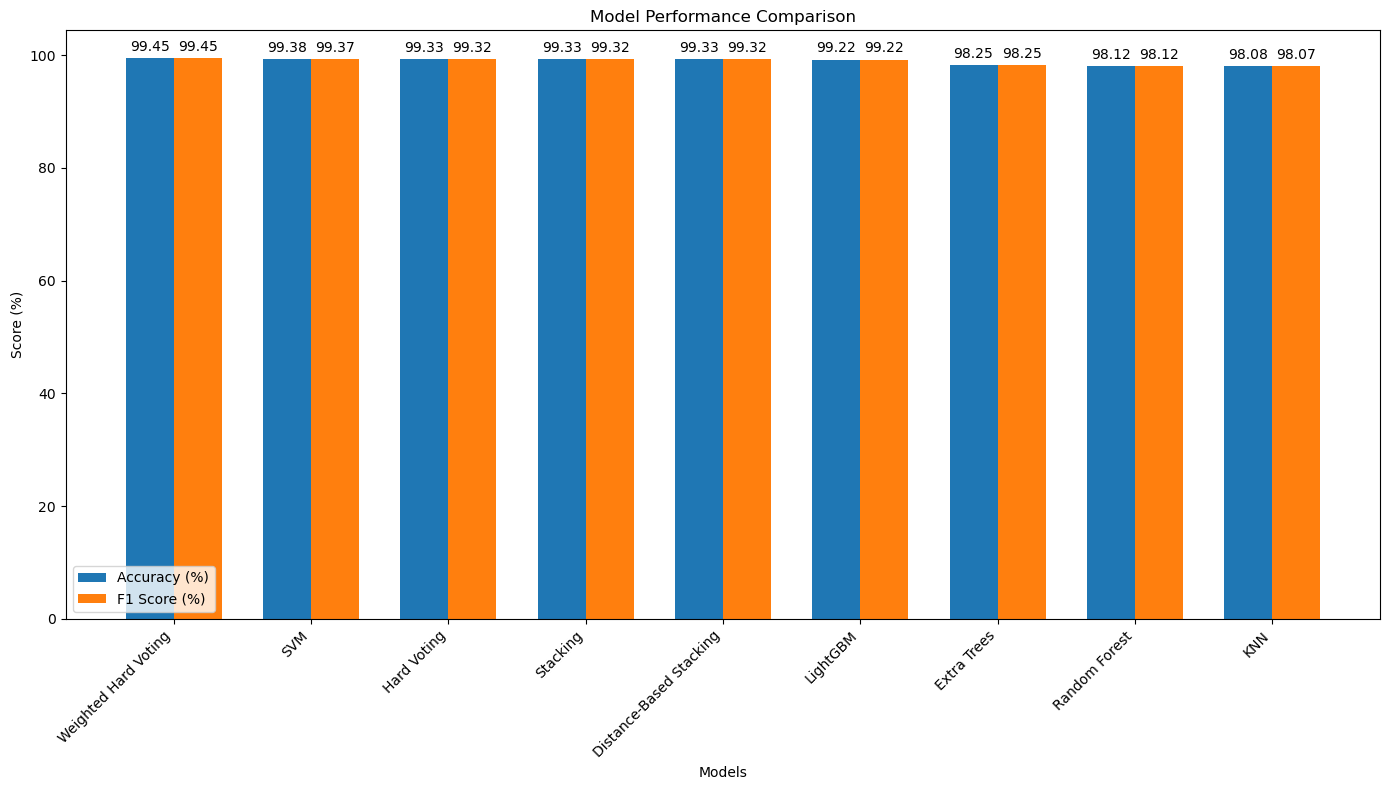

In [155]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ---- Hard Voting (without weights) ----
def hard_voting(predictions_list):
    """
    Simple majority voting without weights
    """
    predictions = []
    for i in range(len(predictions_list[0])):
        # Get votes for this sample from all classifiers
        votes = [model_preds[i] for model_preds in predictions_list]
        
        # Count occurrences of each class
        vote_counts = {}
        for vote in votes:
            vote_counts[vote] = vote_counts.get(vote, 0) + 1
        
        # Find class with most votes
        most_common = max(vote_counts.items(), key=lambda x: x[1])[0]
        predictions.append(most_common)
    
    return np.array(predictions)

# ---- Stacking (without predict_proba) ----
def train_stacking_model():
    """
    Train a stacking ensemble using the base models' predictions as features
    """
    # Get base model predictions on training data
    train_pred_svm = svm_rbf_classifier.predict(combined_train_features)
    train_pred_knn = knn_classifier_cqt.predict(combined_train_features)
    train_pred_et = et_classifier.predict(combined_train_features)
    train_pred_rf = rf_classifier.predict(rf_selected_train_features)
    train_pred_lightgbm = lgbm_classifier.predict(selected_train_features)
    
    # Encode categorical predictions to numerical values for meta-features
    le = LabelEncoder()
    le.fit(train_labels)
    
    # Transform predictions to numerical values
    train_pred_svm_encoded = le.transform(train_pred_svm)
    train_pred_knn_encoded = le.transform(train_pred_knn)
    train_pred_et_encoded = le.transform(train_pred_et)
    train_pred_rf_encoded = le.transform(train_pred_rf)
    train_pred_lightgbm_encoded = le.transform(train_pred_lightgbm)
    
    # Create meta-features from encoded predictions
    meta_features_train = np.column_stack([
        train_pred_svm_encoded,
        train_pred_knn_encoded,
        train_pred_et_encoded,
        train_pred_rf_encoded,
        train_pred_lightgbm_encoded
    ])
    
    # Train meta-learner
    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_features_train, train_labels)
    
    # Encode test predictions for meta-features
    test_pred_svm_encoded = le.transform(test_pred_svm)
    test_pred_knn_encoded = le.transform(test_pred_knn)
    test_pred_et_encoded = le.transform(test_pred_et)
    test_pred_rf_encoded = le.transform(test_pred_rf)
    test_pred_lightgbm_encoded = le.transform(test_pred_lightgbm)
    
    # Create meta-features for test set
    meta_features_test = np.column_stack([
        test_pred_svm_encoded,
        test_pred_knn_encoded,
        test_pred_et_encoded,
        test_pred_rf_encoded,
        test_pred_lightgbm_encoded
    ])
    
    # Make predictions with meta-learner
    stacking_predictions = meta_learner.predict(meta_features_test)
    
    return stacking_predictions

# ---- Alternative Stacking (Distance-Based Method) ----
def train_distance_stacking_model():
    """
    A stacking approach that uses confidence measures derived from KNN distances
    instead of probabilities
    """
    # Define a function to extract a "confidence" measure without predict_proba
    def get_confidence_feature(model, features):
        if hasattr(model, 'kneighbors'):  # For KNN
            # Get distances to k nearest neighbors
            distances, _ = model.kneighbors(features)
            # Use inverse of mean distance as a confidence measure
            return 1.0 / (distances.mean(axis=1) + 0.0001)
        else:
            # For other models, we'll use a dummy confidence of 1
            predictions = model.predict(features)
            return np.ones(len(predictions))
    
    # Get model predictions on training data
    train_pred_svm = svm_rbf_classifier.predict(combined_train_features)
    train_pred_knn = knn_classifier_cqt.predict(combined_train_features)
    train_pred_et = et_classifier.predict(combined_train_features)
    train_pred_rf = rf_classifier.predict(rf_selected_train_features)
    train_pred_lightgbm = lgbm_classifier.predict(selected_train_features)
    
    # Add confidence-like features where possible
    knn_conf_train = get_confidence_feature(knn_classifier_cqt, combined_train_features)
    
    # Encode categorical predictions
    le = LabelEncoder()
    le.fit(np.concatenate([train_labels, test_labels]))
    
    train_pred_svm_encoded = le.transform(train_pred_svm)
    train_pred_knn_encoded = le.transform(train_pred_knn)
    train_pred_et_encoded = le.transform(train_pred_et)
    train_pred_rf_encoded = le.transform(train_pred_rf)
    train_pred_lightgbm_encoded = le.transform(train_pred_lightgbm)
    
    # Create meta-features
    meta_features_train = np.column_stack([
        train_pred_svm_encoded,
        train_pred_knn_encoded,
        train_pred_et_encoded,
        train_pred_rf_encoded,
        train_pred_lightgbm_encoded,
        knn_conf_train  # Add confidence feature
    ])
    
    # Train meta-learner
    meta_learner = LogisticRegression(max_iter=1000)
    meta_learner.fit(meta_features_train, train_labels)
    
    # Create test meta-features
    test_pred_svm_encoded = le.transform(test_pred_svm)
    test_pred_knn_encoded = le.transform(test_pred_knn)
    test_pred_et_encoded = le.transform(test_pred_et)
    test_pred_rf_encoded = le.transform(test_pred_rf)
    test_pred_lightgbm_encoded = le.transform(test_pred_lightgbm)
    
    # Get confidence for test data
    knn_conf_test = get_confidence_feature(knn_classifier_cqt, combined_test_features)
    
    meta_features_test = np.column_stack([
        test_pred_svm_encoded,
        test_pred_knn_encoded,
        test_pred_et_encoded,
        test_pred_rf_encoded,
        test_pred_lightgbm_encoded,
        knn_conf_test
    ])
    
    # Predict with meta-learner
    distance_stacking_predictions = meta_learner.predict(meta_features_test)
    
    return distance_stacking_predictions

# ---- Apply Ensemble Methods ----
# List of all model predictions
all_predictions = [test_pred_svm, test_pred_knn, test_pred_et, test_pred_rf, test_pred_lightgbm]

# Execute ensemble methods
hard_vote_predictions = hard_voting(all_predictions)
stacking_predictions = train_stacking_model()
distance_stacking_predictions = train_distance_stacking_model()

# Calculate metrics for each model
# Accuracy
svm_accuracy = accuracy_score(test_labels, test_pred_svm)
knn_accuracy = accuracy_score(test_labels, test_pred_knn)
et_accuracy = accuracy_score(test_labels, test_pred_et)
rf_accuracy = accuracy_score(test_labels, test_pred_rf)
lgbm_accuracy = accuracy_score(test_labels, test_pred_lightgbm)

hard_vote_accuracy = accuracy_score(test_labels, hard_vote_predictions)
weighted_hard_accuracy = accuracy_score(test_labels, weighted_predictions)
stacking_accuracy = accuracy_score(test_labels, stacking_predictions)
distance_stacking_accuracy = accuracy_score(test_labels, distance_stacking_predictions)

# F1 scores
svm_f1 = f1_score(test_labels, test_pred_svm, average='weighted')
knn_f1 = f1_score(test_labels, test_pred_knn, average='weighted')
et_f1 = f1_score(test_labels, test_pred_et, average='weighted')
rf_f1 = f1_score(test_labels, test_pred_rf, average='weighted')
lgbm_f1 = f1_score(test_labels, test_pred_lightgbm, average='weighted')

hard_vote_f1 = f1_score(test_labels, hard_vote_predictions, average='weighted')
weighted_hard_f1 = f1_score(test_labels, weighted_predictions, average='weighted')
stacking_f1 = f1_score(test_labels, stacking_predictions, average='weighted')
distance_stacking_f1 = f1_score(test_labels, distance_stacking_predictions, average='weighted')

# Create comparison table with all models
results = {
    'Model': [
        'SVM', 
        'KNN', 
        'Extra Trees', 
        'Random Forest', 
        'LightGBM',
        'Hard Voting',
        'Weighted Hard Voting',
        'Stacking',
        'Distance-Based Stacking'
    ],
    'Accuracy (%)': [
        svm_accuracy * 100,
        knn_accuracy * 100,
        et_accuracy * 100,
        rf_accuracy * 100,
        lgbm_accuracy * 100,
        hard_vote_accuracy * 100,
        weighted_hard_accuracy * 100,
        stacking_accuracy * 100,
        distance_stacking_accuracy * 100
    ],
    'F1 Score (Weighted)': [
        svm_f1 * 100,
        knn_f1 * 100,
        et_f1 * 100,
        rf_f1 * 100,
        lgbm_f1 * 100,
        hard_vote_f1 * 100,
        weighted_hard_f1 * 100,
        stacking_f1 * 100,
        distance_stacking_f1 * 100
    ]
}

# Create and display comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy (%)', ascending=False)

# Format the float values to 2 decimal places
results_df['Accuracy (%)'] = results_df['Accuracy (%)'].map('{:.2f}'.format)
results_df['F1 Score (Weighted)'] = results_df['F1 Score (Weighted)'].map('{:.2f}'.format)

print("\n--- Model Performance Comparison ---")
print(results_df.to_string(index=False))

# Create a bar chart comparing the models
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

models = results_df['Model']
acc = results_df['Accuracy (%)'].astype(float)
f1 = results_df['F1 Score (Weighted)'].astype(float)

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, acc, width, label='Accuracy (%)')
rects2 = ax.bar(x + width/2, f1, width, label='F1 Score (%)')

ax.set_xlabel('Models')
ax.set_ylabel('Score (%)')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.savefig('model_comparison.png')
plt.show()